This blog post is a Keras example of the Tensorflow Serving featured in the following blog post: [Serving ML Quickly with TensorFlow Serving and Docker](https://medium.com/tensorflow/serving-ml-quickly-with-tensorflow-serving-and-docker-7df7094aa008). Please read this blog post first, as it explains/links to relevant topics (e.g. how to install docker).

In this post I'll show how to:
1. Save a Keras model in the format expected by Tensorflow Serving
2. Load the model into Tensorflow Serving
3. Query the model with an HTTP client and verify the same output as the local model

We'll use Keras's InceptionV3 model, pretrained over imagenet as our example Keras model and serve it in production.

In [1]:
import os
import tensorflow as tf
import keras
from IPython.display import Image, display
from IPython.core.display import HTML

Using TensorFlow backend.


In [2]:
print(keras.__version__, tf.__version__)

2.2.4 1.13.1


In [3]:
# Install additional packages
!pip3 install requests
import requests

The directory '/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 1. Save a Keras model in the format expected by Tensorflow Serving
In this example, we will load an inception_v3 model pretrained over imagenet, but it can be replaced with any other Keras model that you have trained yourself.

In [4]:
### Load a pretrained inception_v3
inception_model = keras.applications.inception_v3.InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Define a destination path for the model
MODEL_EXPORT_DIR = '/tmp/inception_v3'
MODEL_VERSION = 1
MODEL_EXPORT_PATH = os.path.join(MODEL_EXPORT_DIR, str(MODEL_VERSION))
print("Model dir: ", MODEL_EXPORT_PATH)

Model dir:  /tmp/inception_v3/1


In [6]:
# Before saving the model, let's print the input tensors of the model:
print(inception_model.inputs)

[<tf.Tensor 'input_1:0' shape=(?, 299, 299, 3) dtype=float32>]


In [7]:
# We'll need to create an input mapping, and name each of the input tensors.
# In the inception_v3 Keras model, there is only a single input and we'll name it 'image'
input_names = ['image']
name_to_input = {name: t_input for name, t_input in zip(input_names, inception_model.inputs)}
print(name_to_input)

{'image': <tf.Tensor 'input_1:0' shape=(?, 299, 299, 3) dtype=float32>}


In [8]:
# Save the model to the MODEL_EXPORT_PATH
# Note using 'name_to_input' mapping, the names defined here will also be used for querying the service later
tf.saved_model.simple_save(
    keras.backend.get_session(),
    MODEL_EXPORT_PATH,
    inputs=name_to_input,
    outputs={t.name: t for t in inception_model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/inception_v3/1/saved_model.pb


In [9]:
# Show the saved resources
!ls -la {MODEL_EXPORT_PATH}

total 3368
drwxr-xr-x 3 501 dialout    4096 Jun 28 12:33 .
drwxr-xr-x 3 501 dialout    4096 Jun 28 12:33 ..
-rw-r--r-- 1 501 dialout 3432465 Jun 28 12:33 saved_model.pb
drwxr-xr-x 2 501 dialout    4096 Jun 28 12:33 variables


When running in production, you will usually want to save these model resources and download them to multiple machines behind a load balancer. Next, we will load this model to a Tensorflow Serving docker. 

# 2. Load the model into Tensorflow Serving
All you need for serving this model is to run a Tensorflow Serving docker as described in [Serving ML Quickly with TensorFlow Serving and Docker](https://medium.com/tensorflow/serving-ml-quickly-with-tensorflow-serving-and-docker-7df7094aa008).  
In this context, the source should be the directory we saved the model to (i.e. '/tmp/inception_v3').

1. Copy the saved model to the hosts' specified directory. (source=/tmp/inception_v3 in this example)
2. Run the docker:
```bash
docker run -d -p 8501:8501 --name keras_inception_v3 --mount type=bind,source=/tmp/inception_v3,target=/models/inception_v3 -e MODEL_NAME=inception_v3 -t tensorflow/serving
```
3. Verify that there's network access to the Tensorflow service. In order to get the local docker ip (172.\*.\*.\*) for testing run:

```bash
docker inspect -f '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}' keras_inception_v3
```


In [10]:
# Verify we have network acccess to the TF service
HOST_IP = "172.17.0.3"  # Local docker ip
HOST_PORT = "8501"

!curl {HOST_IP}:{HOST_PORT}

<HTML><HEAD>
<TITLE>404 Not Found</TITLE>
</HEAD><BODY>
<H1>Not Found</H1>
</BODY></HTML>


After verifying the service is up and there are no issues, let's write a client and start querying the service.

# 3. Query the model with an HTTP client and verify the same output as the local model

### Download a Dog (Tibetan Mastiff) and a Cat (Ragdol) image for our tests

In [11]:
def download_file(url, filename):
    response = requests.get(url)
    response.raise_for_status()

    with open(filename, 'wb') as f:
        f.write(response.content)


cat_url = "https://upload.wikimedia.org/wikipedia/commons/c/c0/Ragdoll_Blue_Colourpoint.jpg"
dog_url = "https://3milliondogs.com/blog-assets-two/2015/06/11407122_926045227460335_778769622795895821_n.jpg"

cat_filename = os.path.join("/tmp", "cat.jpg")
dog_filename = os.path.join("/tmp", "dog.jpg")

download_file(cat_url, cat_filename)
download_file(dog_url, dog_filename)

### Define a simple method to query the model locally

In [12]:
import requests
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions


INCEPTIONV3_TARGET_SIZE = (299, 299)


def predict(image_path):
    x = img_to_array(load_img(image_path, target_size=INCEPTIONV3_TARGET_SIZE))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return inception_model.predict(x)

### Define a client class for Tensorflow Serving

In [13]:
# Define a Base client class for Tensorflow Serving
class TFServingClient:
    """
    This is a base class that implements a Tensorflow Serving client
    """
    TF_SERVING_URL_FORMAT = '{protocol}://{hostname}:{port}/v1/models/{endpoint}:predict'

    def __init__(self, hostname, port, endpoint, protocol="http"):
        self.protocol = protocol
        self.hostname = hostname
        self.port = port
        self.endpoint = endpoint

    def _query_service(self, req_json):
        """

        :param req_json: dict (as define in https://cloud.google.com/ml-engine/docs/v1/predict-request)
        :return: dict
        """
        server_url = self.TF_SERVING_URL_FORMAT.format(protocol=self.protocol,
                                                       hostname=self.hostname,
                                                       port=self.port,
                                                       endpoint=self.endpoint)
        response = requests.post(server_url, json=req_json)
        response.raise_for_status()
        return np.array(response.json()['predictions'])
    

# Define a specific client for our inception_v3 model
class InceptionV3Client(TFServingClient):
    # INPUT_NAME is the config value we used when saving the model (the only value in the `input_names` list)
    INPUT_NAME = "image"
    TARGET_SIZE = INCEPTIONV3_TARGET_SIZE
    
    def load_image(self, image_path):
        """Load an image from path"""
        img = img_to_array(load_img(image_path, target_size=self.TARGET_SIZE))
        return preprocess_input(img)
    
    def predict(self, image_paths):
        imgs = [self.load_image(image_path) for image_path in image_paths]
        
        # Create a request json dict
        req_json = {
            "instances": [{self.INPUT_NAME: img.tolist()} for img in imgs]
        }
        print(req_json)
        return self._query_service(req_json)

In [14]:
# Instantiate a client
hostname = "172.17.0.3"
port = "8501"
endpoint="inception_v3"
client = InceptionV3Client(hostname=hostname, port=port, endpoint=endpoint)

### Validate Results
Query the image using both local/TF serving models and validate the results are the same

In [15]:
cat_local_preds = predict(cat_filename)
cat_remote_preds = client.predict([cat_filename])

dog_local_preds = predict(dog_filename)
dog_remote_preds = client.predict([dog_filename])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
# Validate the prediction values are the same for the local and remote models
assert np.allclose(cat_local_preds, cat_remote_preds, atol=1e-07)
assert np.allclose(dog_local_preds, dog_remote_preds, atol=1e-07)

We have now saved a Keras model in Tensorflow Serving. This also works for models with multiple inputs as long as you map each input to a name and use it also in the Tensorflow Serving http request.

Now that we have an InceptionV3 model, let's try to query a few images and see how good the classifications are.

# Show model predictions

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image


def grid_iterator(n_rows, n_cols, axis_size=2.5, total=None, fig_title=None):
    """
    matplotlib helper method for plotting a grid of graphs


    :param n_rows: int
    :param n_cols: int
    :param axis_size: float
    :param total: int (stopping condition - stop before n_rows * n_cols subplots are filled in the grid)
    :param fig_title: str
    """
    fig = plt.figure()
    gs = gridspec.GridSpec(n_rows, n_cols, top=1., bottom=0., right=1., left=0., hspace=0.15, wspace=0.1)

    index = 0
    for r in range(n_rows):
        for c in range(n_cols):
            ax = fig.add_subplot(gs[r, c])
            yield index, ax

            index += 1
            # Allowing for not filling all spots
            if total and index >= total:
                break

    width, height = n_cols * axis_size, n_rows * axis_size
    fig.set_size_inches(width, height)

    # Add title to the figure
    if fig_title is not None:
        fig.suptitle(fig_title, fontsize=16, y=1.05)


def get_titles(predicts):
    """
    Helper method that concats the highest classification with all classification that have a score >=0.1
    """
    titles = []
    for decoded_pred in decode_predictions(predicts):
        res = []
        for _, cls, score in decoded_pred:
            if score >= 0.1 or not res:
                res.append("%s(%.2f)" % (cls, score))

        title = ",".join(res)
        titles.append(title)
    return titles

In [18]:
# Define a list of image urls
image_urls = [
    dog_url,
    cat_url,
    "https://upload.wikimedia.org/wikipedia/commons/1/1f/Oryctolagus_cuniculus_Rcdo.jpg",
    "https://cdn.omlet.co.uk/images/originals/healthy-rabbits.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQjfw20fp-pcOqDMzBU-kOSgU7LL5myy69bDzatFTukdh4U3DV28A",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR-_q5kjh1vrsHkwQQi52_xYAA72TonOGseWg2y9kp5DcLAda4p",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRVrGcFxHwHcIFWSZuCmdtRAlz45oGCY91E3ymr20UsjqVwhoGS",
    "https://i.pinimg.com/originals/9b/e4/41/9be44139b01b18221fa35340e8da50fc.jpg",
    "https://wwwselwomarinaes-jrzviv0e.stackpathdns.com/sites/selwomarina.es/files/uploads/styles/adaptive/public/animales/media/web_img_0001.jpg?itok=2Jchrtuf",
    "https://upload.wikimedia.org/wikipedia/commons/4/40/Canada_goose_on_Seedskadee_NWR_%2827826185489%29.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyojh-pUD9QUSpbcVcUKGcUQC_2exNPliU1ddkiinZUA3kf_KPCw",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQz0QAkiDOwzVBkRVcjRHtiJceYTymUa3uBXEFBjPxj9Bkbi5jUBA",
    "https://i0.wp.com/learnaboutanimals.co/wp-content/uploads/2016/07/green-mamba.jpg?resize=567%2C375",
]

# Download files
img_files = []
for i, image_url in enumerate(image_urls):
    filename = os.path.join("/tmp", "%d.jpg" % i)
    download_file(image_url, filename)
    img_files.append(filename)

In [19]:
# Run predictions
%time predicts = client.predict(img_files)
assert len(predicts) == len(img_files)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CPU times: user 7.42 s, sys: 520 ms, total: 7.94 s
Wall time: 13.3 s


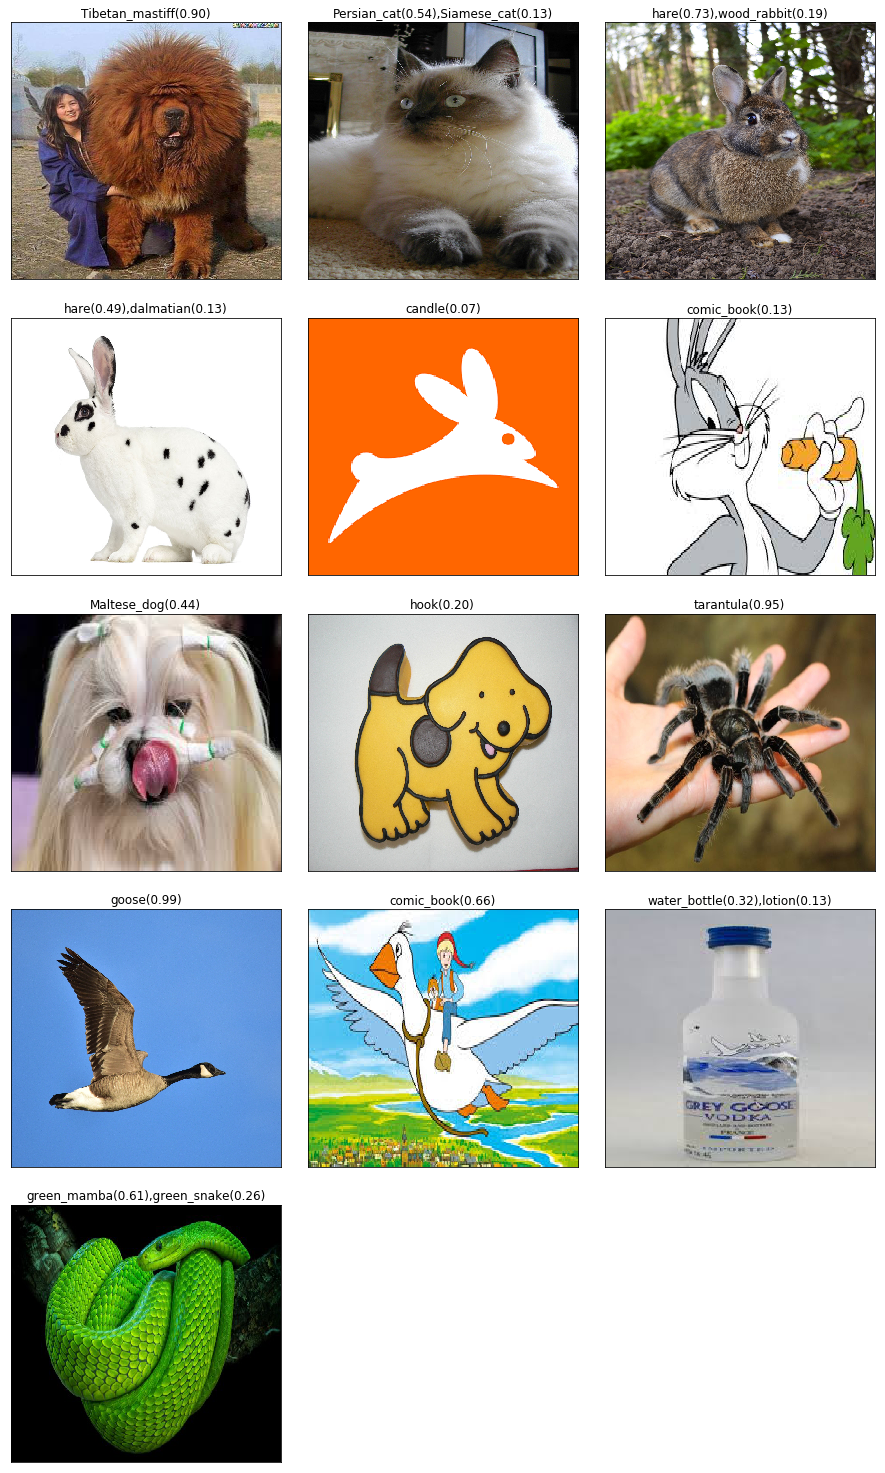

In [20]:
titles = get_titles(predicts)

for i, ax in grid_iterator(n_rows=5, n_cols=3, axis_size=4, total=len(img_files)):
    title = titles[i]
    img = Image.open(img_files[i])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    ax.set_title(title)

Looks like our Image Classification service is working pretty well :-).